In [1]:
%load_ext autoreload
%autoreload 2

# Spillover Figure replication

This is the replication code for the Fig 3 exploring the changes in future severity conditional on proximity exposure to wildfires. In this notebook we replicate:
 - Fig 3: Spillover protection
 - Supplementary Plot 6: Population filtering to calculate effect in just remote fires and Standararized Differences from weighting in SC.
 - Supplementary Plot 7: Additional results per severity class and distance
 - Supplementary Plot 11: Run regression using a small sample of fires (< 3,000 acres)

In [2]:
from pathlib import Path

import geopandas as gpd
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rioxarray
import xarray as xr
from matplotlib.colors import (
    BoundaryNorm,
    LinearSegmentedColormap,
    ListedColormap,
    to_rgba,
)
from mpl_toolkits.axes_grid1 import make_axes_locatable
from prescribed.estimate.calculate_estimator import (
    calculate_spillover_estimator,
)
from prescribed.plot import plot_std_diffs, template_plots
from prescribed.utils import calculate_fire_pop_dens

matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["ps.fonttype"] = 42


# Set the font to be serif, rather than sans
plt.rcParams["font.family"] = "Helvetica Neue"

# Set the font size to be 12
plt.rcParams["font.size"] = 12

### Load necessary data to define treatments and exposure

In [3]:
pop_zip = list(
    Path("/mnt/sherlock/oak/prescribed_data/raw/population").glob("*.tif")
)
pop_dict = {
    int(p.stem.split("_")[-3]): p
    for p in Path("/mnt/sherlock/oak/prescribed_data/raw/population").glob(
        "*.tif"
    )
}

In [4]:
mtbs = gpd.read_file(
    "/mnt/sherlock/oak/prescribed_data/geoms/mtbs_perims_DD_updated/mtbs_perims_DD.shp"
)

mtbs_ca = mtbs[
    (mtbs.Event_ID.str.contains("CA"))
    & (mtbs.Incid_Type.isin(["Wildfire", "Prescribed Fire"]))
].to_crs("3310")
mtbs_ca["Ig_Date"] = pd.to_datetime(mtbs_ca.Ig_Date)
mtbs_ca["year"] = mtbs_ca.Ig_Date.dt.year

# Load California boundaries
ca = gpd.read_file(
    "/mnt/sherlock/oak/prescribed_data/geoms/california_geom/datacalifornia_geom.shp"
).to_crs("4326")

template = rioxarray.open_rasterio(
    "/mnt/sherlock/oak/prescribed_data/geoms/templates/template.tif"
)

# Add land types
land_type = pd.read_feather(
    "/mnt/sherlock/oak/prescribed_data/processed/land_type/land_type.feather"
)

## Sup Fig 6: Remote Fires using population filter

In [5]:
pop_dens = calculate_fire_pop_dens(
    geoms=mtbs_ca,
    pop_raster_path="/mnt/sherlock/oak/prescribed_data/raw/population",
    mask=ca,
    template=template,
)

Calculating population density...: 100%|██████████| 1886/1886 [00:42<00:00, 43.97it/s]


Fires above 50.0th-percentile: 943
Fires below 50.0th-percentile: 943


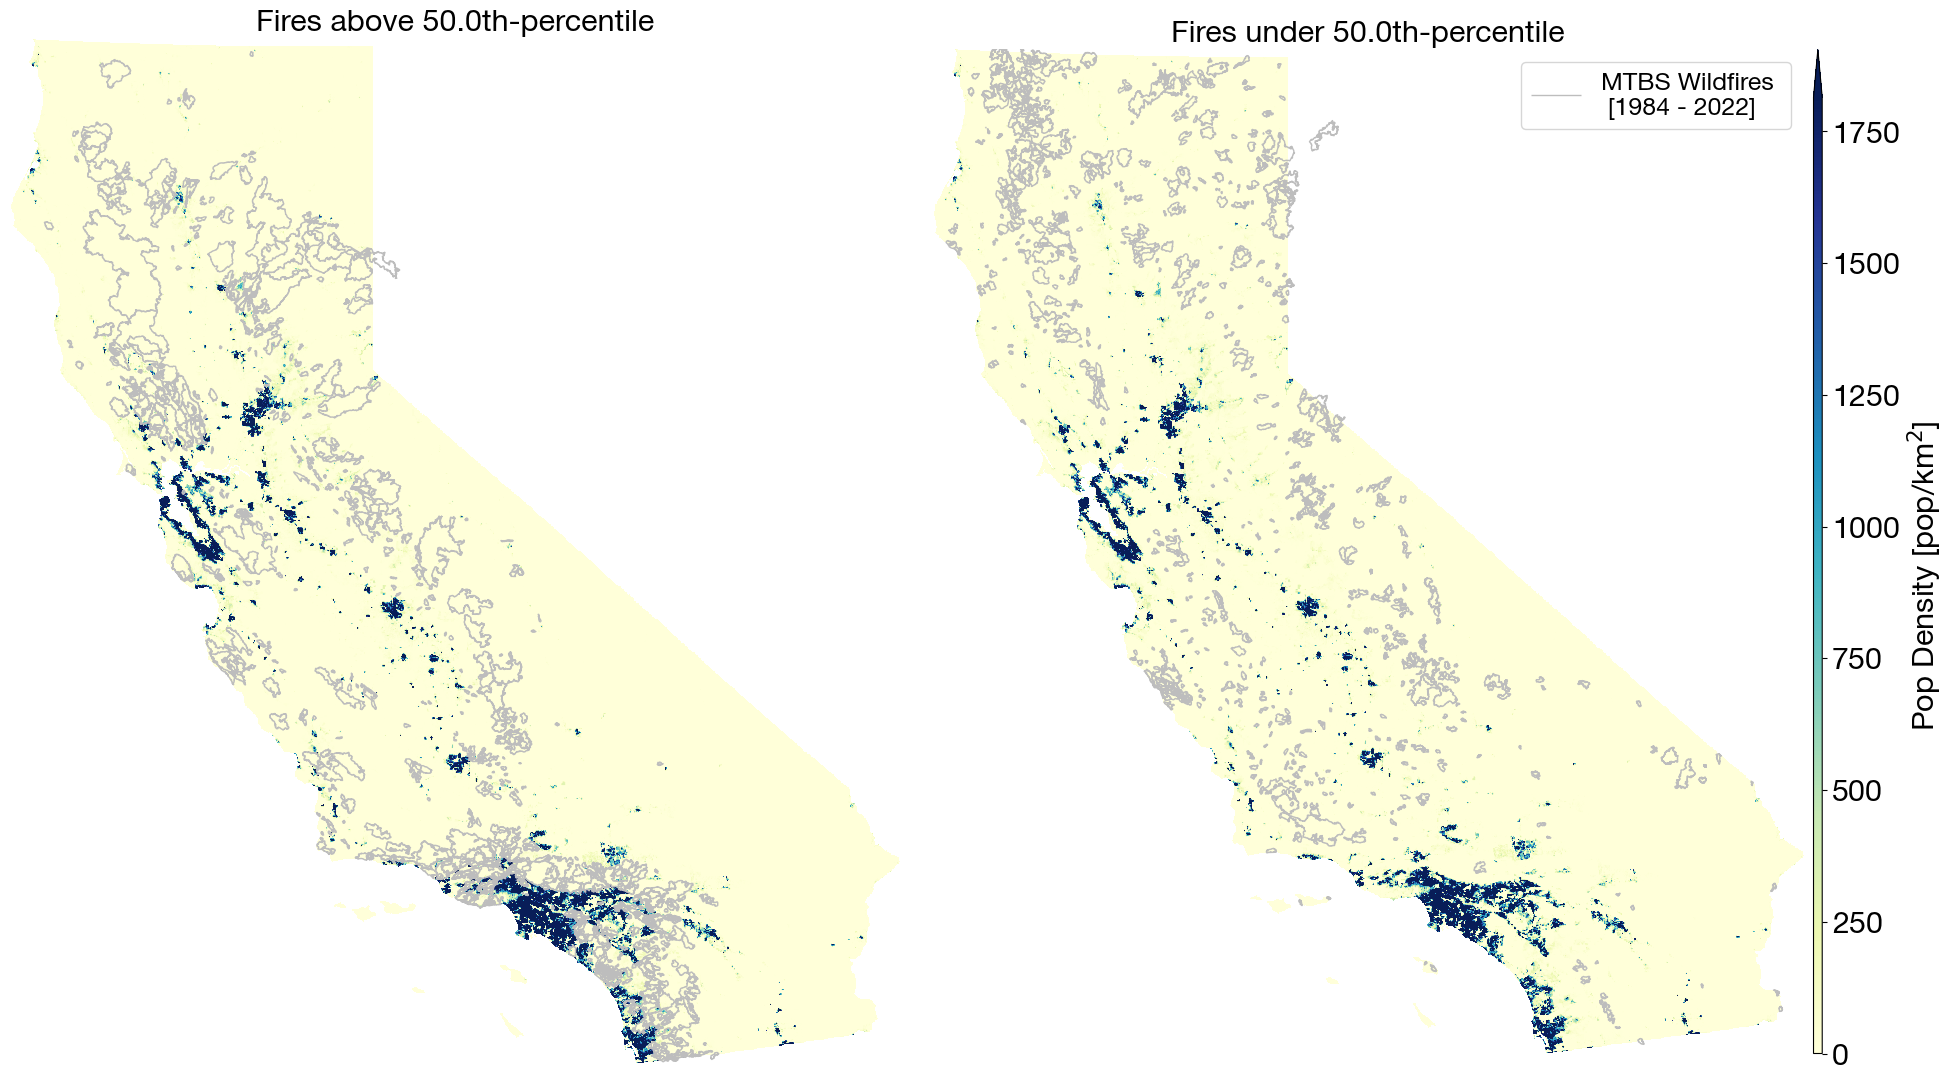

In [6]:
# Set the font size to be 12
plt.rcParams["font.size"] = 22

############################# PREPARE DATA FOR PLOT ############################
ds = rioxarray.open_rasterio(pop_dict[2020]).squeeze()

with xr.set_options(keep_attrs=True):
    clip_box = ds.rio.clip_box(*ca.total_bounds)
    cal_pop = clip_box.rio.clip(
        ca.geometry.values, ca.crs, drop=True, invert=False
    ).rio.reproject_match(template)

    cal_pop = xr.where(cal_pop == ds.attrs["_FillValue"], np.nan, cal_pop)
################################################################################


fig, ax = plt.subplots(1, 2, figsize=(20, 20))

thresh_def = 0.50

cal_pop.plot(robust=True, ax=ax[0], cmap="YlGnBu", add_colorbar=False)

tresh = pop_dens.total_pop.quantile([thresh_def]).values[0]
subset_events = pop_dens[pop_dens.total_pop >= tresh]
print(f"Fires above {thresh_def * 100}th-percentile: {subset_events.shape[0]}")
subset_events.geometry.boundary.plot(
    ax=ax[0],
    color="#bdbdbd",
    linewidth=1,
    alpha=1,
)

template_plots(ax[0], no_axis=True, ylab="", xlab="")

ax[0].set_title(f"Fires above {thresh_def * 100}th-percentile", fontsize=22)

divider = make_axes_locatable(ax[1])
cax = divider.append_axes("right", size="1%", pad=0.1)

# Low density
cal_pop.plot(
    robust=True,
    ax=ax[1],
    cbar_ax=cax,
    rasterized=True,
    cmap="YlGnBu",
    cbar_kwargs={
        "label": r"Pop Density [pop/km$^2$]",
        "shrink": 0.5,
        "aspect": 10,
    },
)

tresh = pop_dens.total_pop.quantile([thresh_def]).values[0]
subset_events = pop_dens[pop_dens.total_pop <= tresh]

print(f"Fires below {thresh_def * 100}th-percentile: {subset_events.shape[0]}")

subset_events.geometry.boundary.plot(
    ax=ax[1],
    color="#bdbdbd",
    linewidth=1,
    alpha=1,
    label="MTBS Wildfires \n [1984 - 2022]",
)
ax[1].legend(loc="upper right", fontsize=18)

template_plots(ax[1], no_axis=True, ylab="", xlab="")

ax[1].set_title(f"Fires under {thresh_def * 100}th-percentile", fontsize=22)

# Save plot
plt.tight_layout()
plt.savefig("../figs/pop_density_fires.pdf", dpi=400, transparent=True)

In [ ]:
from scipy import stats

size_sample = mtbs_ca[
    mtbs_ca.Event_ID.isin(subset_events.Event_ID) & (mtbs_ca.year >= 2000)
].BurnBndAc.values
size_total = mtbs_ca.BurnBndAc.values

t_val, p_val = stats.ttest_ind(size_sample, size_total, equal_var=False)
print(f"Size t-test: t_val={t_val}, p_val={p_val}")

Size t-test: t_val=-0.7446286264327231, p_val=0.45661223779485827


In [ ]:
dnbr = pd.read_feather(
    "/mnt/sherlock/oak/prescribed_data/processed/dnbr_gee_inmediate/dnbr_long.feather"
)
dnbr = dnbr.merge(
    mtbs_ca[["Event_ID", "year"]],
    right_on="Event_ID",
    left_on="event_id",
    how="left",
)

dnbr_sample = (
    dnbr[dnbr.event_id.isin(subset_events.Event_ID) & (dnbr.year >= 2000)]
    .groupby("event_id")
    .dnbr.mean()
    .values
)
dnbr_total = dnbr.groupby("event_id").dnbr.mean().values

t_val, p_val = stats.ttest_ind(dnbr_sample, dnbr_total, equal_var=False)
print(f"DNBR t-test: t_val={t_val}, p_val={p_val}")

DNBR t-test: t_val=-1.7048546292780582, p_val=0.08856942481289702


In [68]:
p_val

0.016771963730783615

In [57]:
test_df = pd.read_feather(
    "/mnt/sherlock/oak/prescribed_data/processed/distance_treatments/wildfire_distances_20000.feather"
)

# Check the acreage of fires in the spillover sample

ids = subset_events[
    subset_events.Event_ID.isin(test_df.wildfire.unique())
    & (subset_events.Ig_Date.dt.year >= 2008)
].Event_ID.unique()

mtbs_ca[mtbs_ca.Event_ID.isin(ids)].BurnBndAc.describe()

count       310.000000
mean      14422.967742
std       30246.149574
min        1014.000000
25%        1790.000000
50%        3847.500000
75%       12849.250000
max      306811.000000
Name: BurnBndAc, dtype: float64

/tmp/ipykernel_46462/2195208405.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(
/home/topcat/miniforge3/envs/prescribed/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


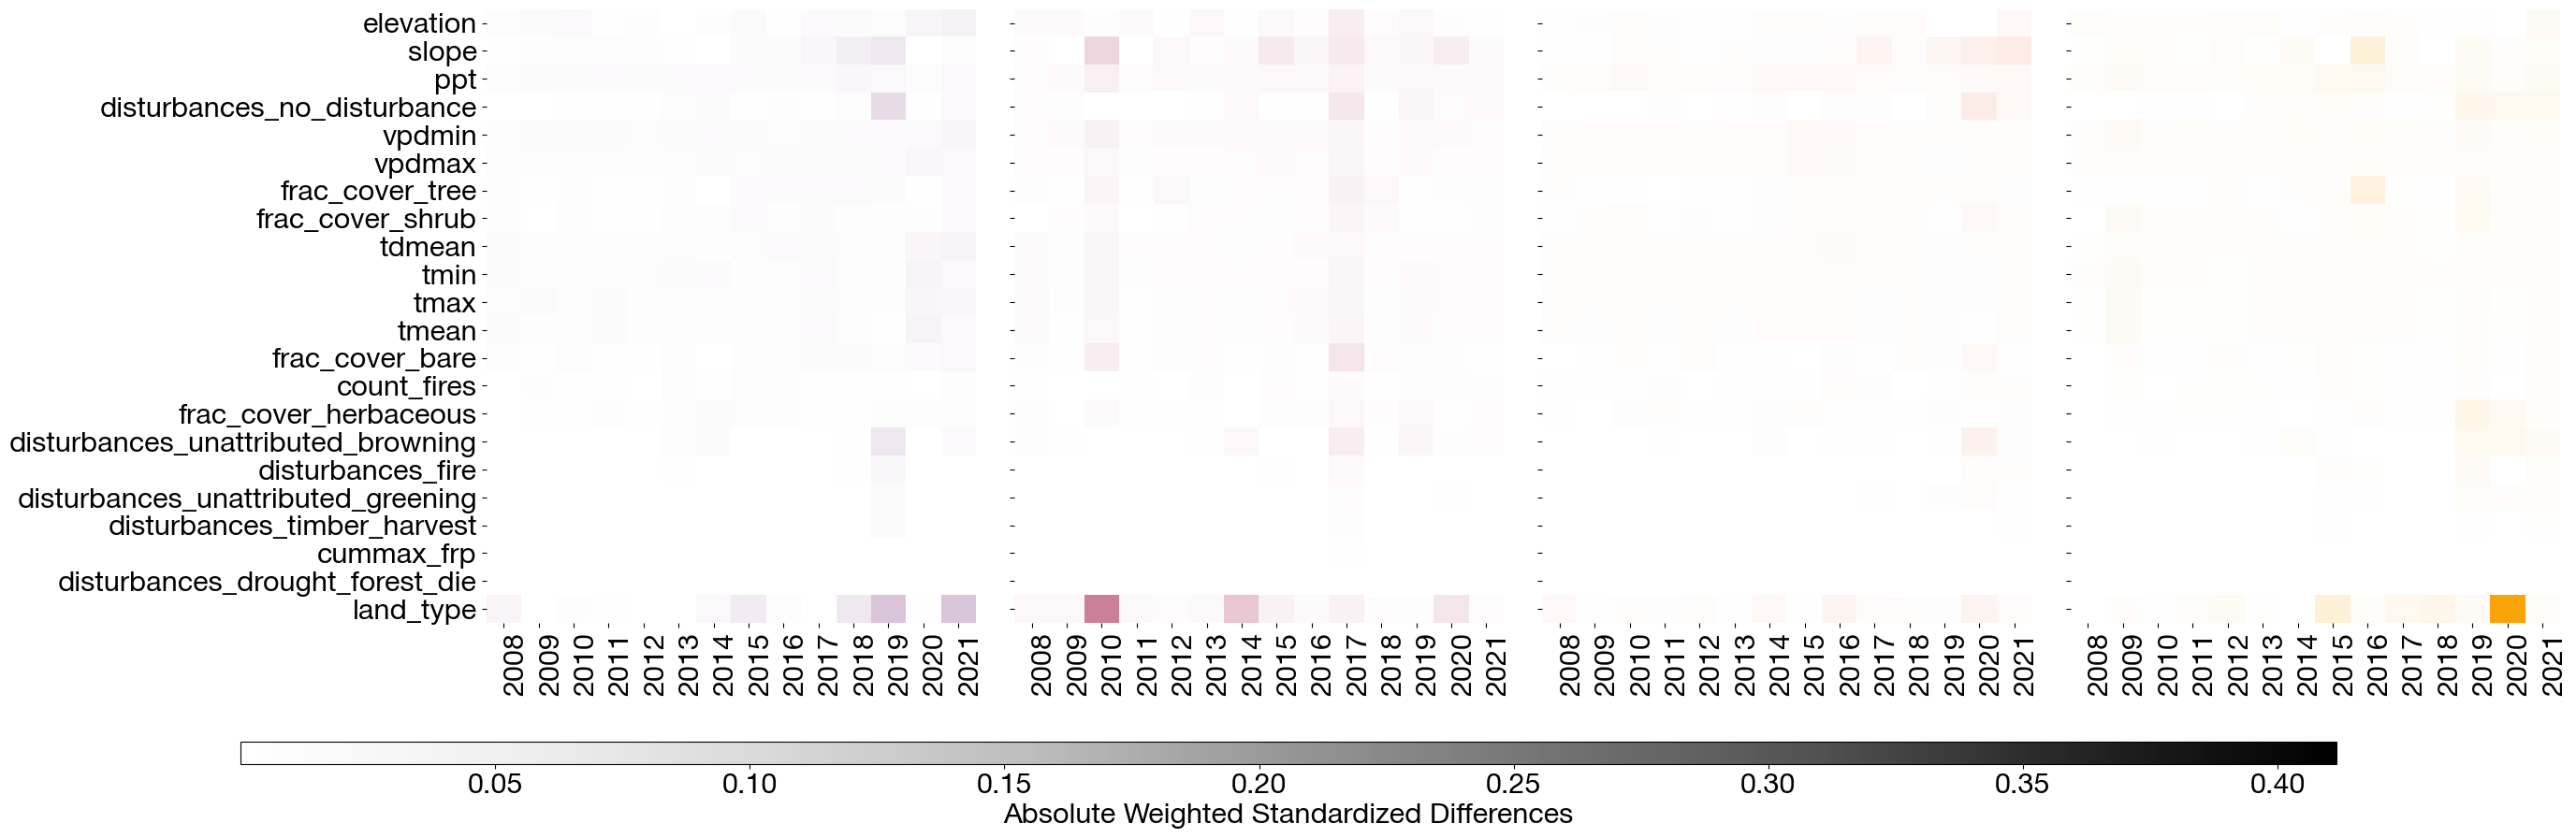

In [10]:
# Set the font size to be 12
plt.rcParams["font.size"] = 22

dists = [2_000, 5_000, 10_000, 15_000]

fig, ax = plt.subplots(
    1, len(dists), figsize=(28, 8), sharey=True, layout="tight"
)
colors = cm.inferno(np.linspace(0.3, 0.8, len(dists)))


min_list = []
max_list = []
for dist, color, ax in zip(dists, colors, ax.flatten()):
    cmap = LinearSegmentedColormap.from_list(
        "", [to_rgba(color, 0), to_rgba(color, 1)]
    )

    _, std_min, std_max = plot_std_diffs(
        std_diffs_df=f"../tyra/treatment_spillovers_{dist}/best_model_asmd_std_diffs.csv",
        palette=cmap,
        ax=ax,
        draw_cbar=False,
        sorted=False,
        labels_y=True,
        rotation_x=90,
        drop_vars=["Intercept", "aspect", "curvature"],
        vmax=0.41154936,
        vmin=8.9584755e-07,
    )
    min_list.append(std_min)
    max_list.append(std_max)

# Add a colorbar at the bottom outside the plot using the max and min of all the data
fig.subplots_adjust(bottom=0.1)
cbar_ax = fig.add_axes([0.1, -0.05, 0.8, 0.03])

# Create the colorbar
sm = plt.cm.ScalarMappable(
    cmap="Grays", norm=plt.Normalize(vmin=min(min_list), vmax=max(max_list))
)
sm._A = []
cbar = fig.colorbar(sm, cax=cbar_ax, orientation="horizontal")
cbar.set_label("Absolute Weighted Standardized Differences", fontsize=22)

# Save as PDF
plt.savefig(
    "../figs/spillover_std_diffs.pdf",
    dpi=400,
    transparent=False,
    bbox_inches="tight",
    pad_inches=0.1,
)

## Fig 3. Spillover effects of wildfire exposure

In [5]:
from prescribed.build.build_data import classify_dnbr, classify_frp

dnbr = pd.read_feather(
    "/mnt/sherlock/oak/prescribed_data/processed/dnbr_gee_inmediate/dnbr_long.feather"
)
# Add years using mtbs data
dnbr = dnbr.merge(
    mtbs_ca[["Event_ID", "year"]], left_on="event_id", right_on="Event_ID"
)
dnbr["fire"] = 1

# Load FRP data with nominal confidence and fire with everything where FRP > 0
frp = pd.read_feather(
    "/mnt/sherlock/oak/prescribed_data/processed/frp_nominal_conf/frp_concat.feather"
).drop(columns=["lat", "lon"])

# Load treat defniitions
treats_dist = pd.read_feather(
    "/mnt/sherlock/oak/prescribed_data/processed/distance_treatments/wildfire_distances_20000.feather"
).drop(columns=["lat", "lon", "donut", "wildfire"])

raw_dnbr = classify_dnbr(dnbr)
raw_frp = classify_frp(frp)

In [6]:
hc_lists = {
    "All wildfires": [0, 1, 2, 3, 4],
    "High-severity wildfires": [2, 3, 4],
    "Very High-severity wildfires": [3, 4],
}

list_df = []
for key, high_class in hc_lists.items():
    if key == "All wildfires":
        out_df = raw_frp[raw_frp.class_frp.isin(high_class)]
        var = "fire"
    elif key == "High-intensity wildfires":
        out_df = raw_frp[raw_frp.class_frp.isin(high_class)]
        var = "fire"
    elif key == "High-severity wildfires":
        out_df = raw_dnbr[raw_dnbr.class_dnbr.isin(high_class)]
        var = "fire"
    elif key == "Very High-intensity wildfires":
        out_df = raw_frp[raw_frp.class_frp.isin(high_class)]
        var = "fire"
    elif key == "Very High-severity wildfires":
        out_df = raw_dnbr[raw_dnbr.class_dnbr.isin(high_class)]
        var = "fire"

    est_dfs_list = []
    for distance in [2_000, 5_000, 10_000, 15_000]:
        weights = pd.read_csv(
            f"../tyra/treatment_spillovers_{distance}/best_model_asmd_weights.csv"
        )

        past_dist = 0
        df = calculate_spillover_estimator(
            treatments=treats_dist,
            weights=weights,
            fire_data=out_df,
            focal_years=np.arange(2008, 2023),
            max_distance=distance,
            min_distance=0,
            estimator="rr",
            dep_var="fire",
            pooling=True,
            cluster_var="year",
            formula="att ~ lag",
            freq_weights="control_mean",
            max_lags=14,
            rr=True,
        )
        past_dist = distance

        est_dfs_list.append(df)

    df = pd.concat(est_dfs_list)
    df["control_group"] = key
    list_df.append(df)

final_df = pd.concat(list_df)

Calculate estimate for focal year: 100%|██████████| 15/15 [00:00<00:00, 19.87it/s]
/home/topcat/projects/extract/src/prescribed/estimate/calculate_estimator.py:641: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept = coefficients[0]
/home/topcat/projects/extract/src/prescribed/estimate/calculate_estimator.py:642: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  slope = coefficients[1]
/home/topcat/projects/extract/src/prescribed/estimate/calculate_estimator.py:675: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consist

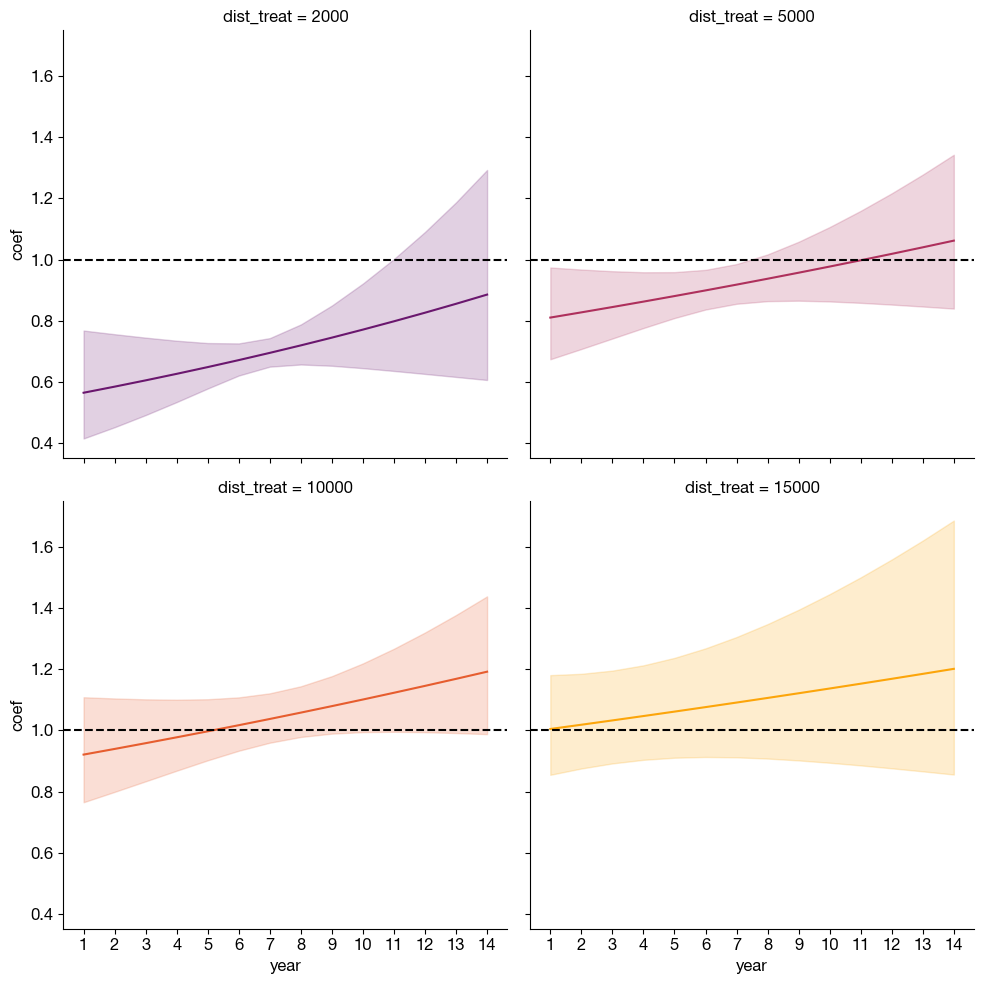

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Assuming final_df is your DataFrame
unique_dist_treats = final_df.dist_treat.unique()
num_colors = len(unique_dist_treats)
green_colors = cm.inferno(np.linspace(0.3, 0.8, num_colors))

# Create a color dictionary
color_dict = {
    dist_treat: color
    for dist_treat, color in zip(unique_dist_treats, green_colors)
}

# Create the relplot
g = sns.relplot(
    data=final_df[final_df.control_group == "All wildfires"],
    x="year",
    y="coef",
    col="dist_treat",
    hue="dist_treat",
    kind="line",
    legend=False,
    palette=color_dict,
    height=5,
    col_wrap=2,
    aspect=1,
    facet_kws={"sharey": True, "sharex": True},
)

# Add fill_between and other elements to each facet
for ax, (dist_treat, data) in zip(g.axes.flat, g.data.groupby(["dist_treat"])):
    data = data.sort_values("year")
    color = color_dict[dist_treat[0]]

    ax.fill_between(
        data["year"], data["low_ci"], data["high_ci"], alpha=0.2, color=color
    )
    ax.axhline(1, color="black", linestyle="--")

    ax.set_xticks(range(1, 15))
    ax.set_xticklabels(range(1, 15))


# Save to PDF
plt.savefig(
    "../figs/main_plot_spills.pdf",
    bbox_inches="tight",
    dpi=400,
    transparent=True,
)

In [6]:
weight_var = "att_se"

est_dfs_list, est_non_pool_list = [], []
for distance in [2_000, 5_000, 10_000, 15_000]:
    weights = pd.read_csv(
        f"../tyra/treatment_spillovers_{distance}/best_model_asmd_weights.csv"
    )

    past_dist = 0
    df = calculate_spillover_estimator(
        treatments=treats_dist,
        weights=weights,
        fire_data=dnbr.dropna(),
        focal_years=np.arange(2008, 2021),
        max_distance=distance,
        min_distance=past_dist,
        estimator="att",
        dep_var="dnbr",
        pooling=True,
        cluster_var="year",
        formula="att ~ lag",
        max_lags=14,
        rr=False,
        weight_var=weight_var,
    )

    est_dfs_list.append(df)

    df_non_pool = calculate_spillover_estimator(
        treatments=treats_dist,
        weights=weights,
        fire_data=dnbr.dropna(),
        focal_years=np.arange(2008, 2021),
        max_distance=distance,
        min_distance=past_dist,
        estimator="att",
        dep_var="dnbr",
        pooling=False,
        cluster_var="year",
        formula="att ~ lag",
        max_lags=14,
        rr=False,
        weight_var=weight_var,
    )
    past_dist = distance

    est_non_pool_list.append(df_non_pool)

df = pd.concat(est_dfs_list)
df_non_pool = pd.concat(est_non_pool_list)


Calculate estimate for focal year: 100%|██████████| 13/13 [00:01<00:00, 12.61it/s]


In [10]:
df.to_csv("../data/results/att_spillover_new.csv", index=False)

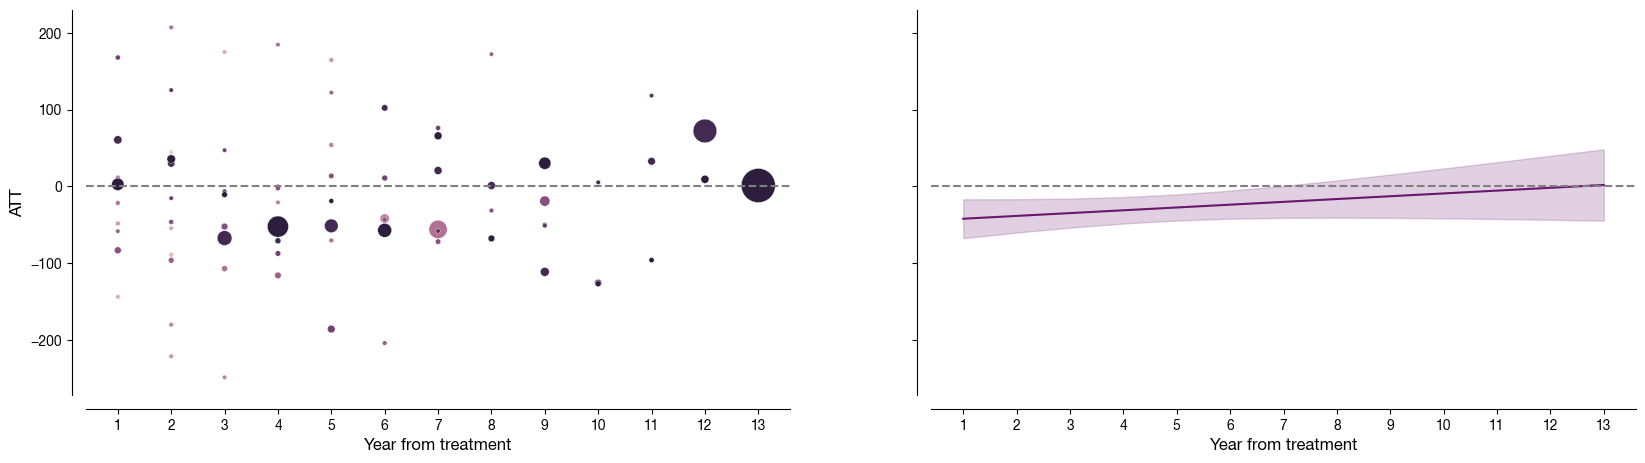

In [8]:
from prescribed.plot import template_plots
import seaborn as sns


dists = [2_000, 5_000, 10_000, 15_000]
colors = cm.inferno(np.linspace(0.3, 0.8, len(dists)))

cmap = LinearSegmentedColormap.from_list(
    "", [to_rgba(colors[0], 0), to_rgba(colors[0], 1)]
)

fig, ax = plt.subplots(1, 2, figsize=(20, 5), sharey=True)
df.sort_values("year", inplace=True)

df_non_pool["w"] = 1 / df_non_pool["att_var"]

sns.scatterplot(
    data=df_non_pool[df_non_pool.dist_treat == 2000],
    x="lag",
    y="att",
    hue="year",
    color=colors[0],
    ax=ax[0],
    size="w",
    sizes=(10, 600),
    legend=False,
)

sns.lineplot(
    data=df[df.dist_treat == 2000],
    x="year",
    y="coef",
    color=colors[0],
    ax=ax[1],
)

ax[1].fill_between(
    df[df.dist_treat == 2000].year,
    df[df.dist_treat == 2000].low_ci,
    df[df.dist_treat == 2000].high_ci,
    alpha=0.2,
    color=colors[0],
)
ax[1].axhline(1, color="gray", linestyle="--")
ax[0].axhline(1, color="gray", linestyle="--")
template_plots(ax[1], ylab="ATT", xlab="Year from treatment")
template_plots(ax[0], ylab="ATT", xlab="Year from treatment")

max_val = df["year"].max()
ax[0].set_xticks(range(1, np.int8(max_val) + 1))
ax[1].set_xticks(range(1, np.int8(max_val) + 1))


# Save to PDF
plt.savefig(
    "../figs/fig_results_spillovers_att_all.pdf",
    bbox_inches="tight",
    dpi=400,
    transparent=True,
)

## Supplementary Figure 7: Complete spillover effects 

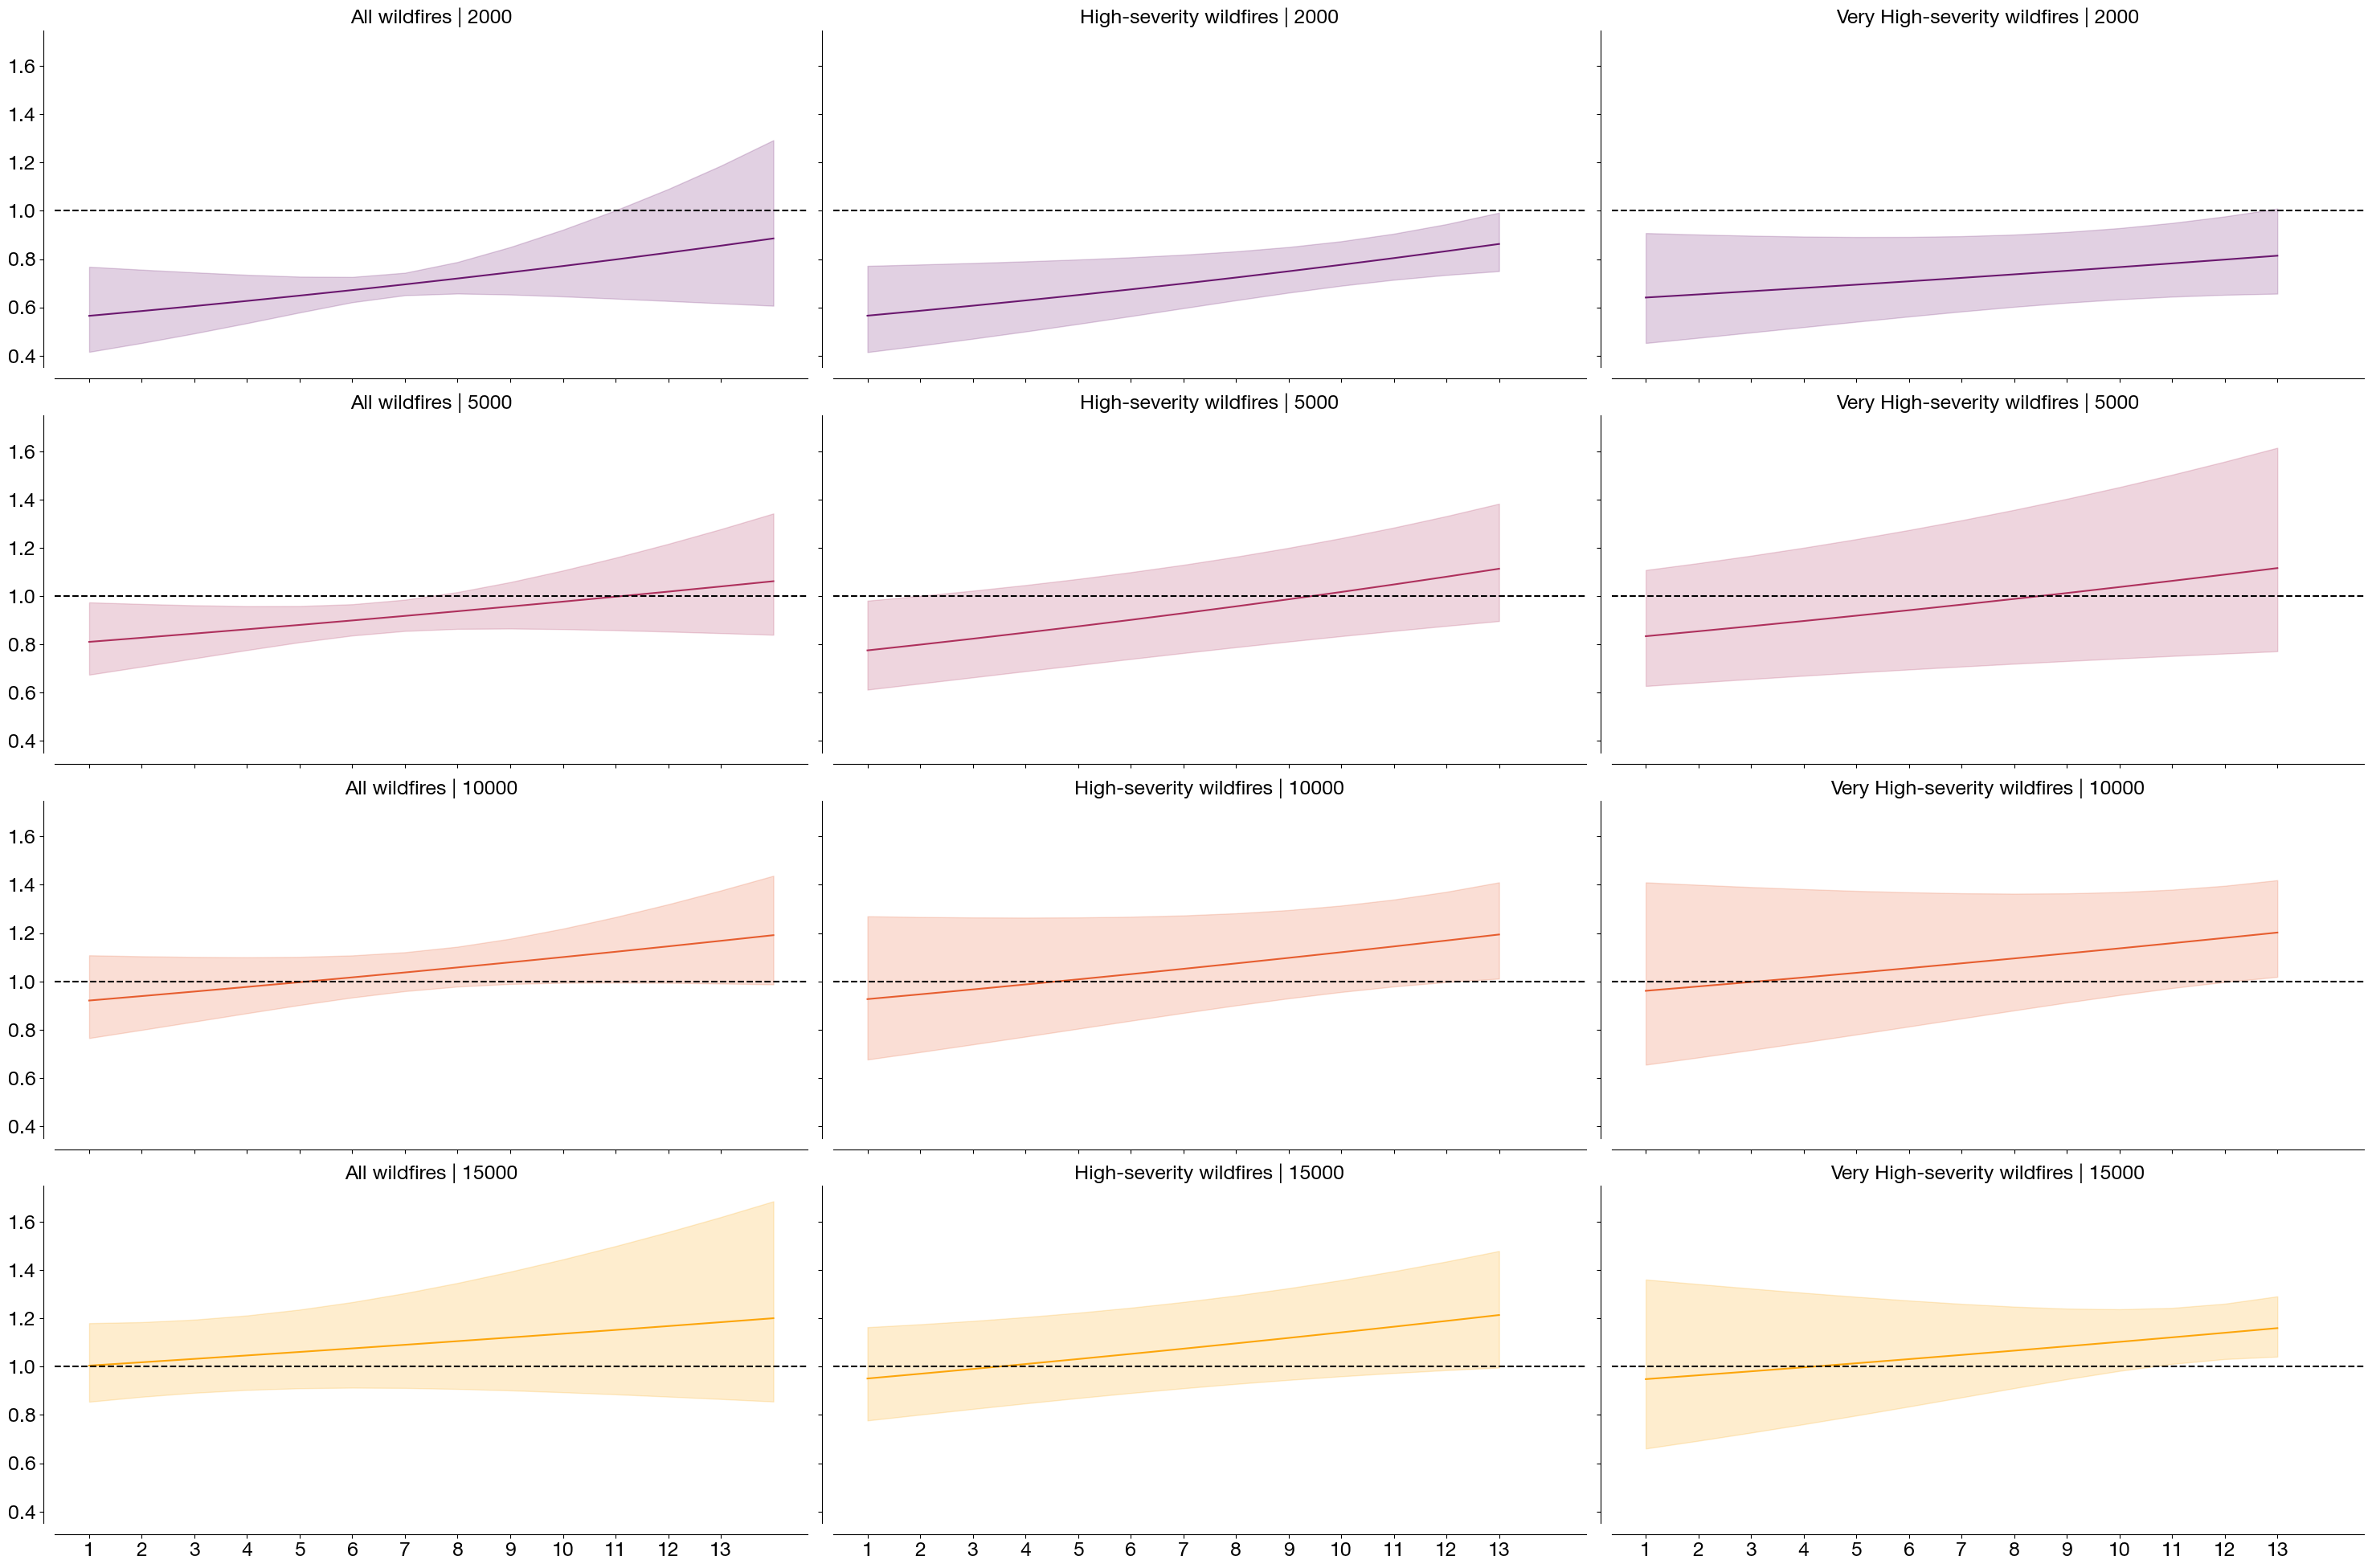

In [30]:
# Set the font to be serif, rather than sans
plt.rcParams["font.family"] = "Helvetica Neue"

# Set the font size to be 12
plt.rcParams["font.size"] = 18

# Assuming final_df is your DataFrame
unique_dist_treats = final_df.dist_treat.unique()
num_colors = len(unique_dist_treats)
green_colors = cm.inferno(np.linspace(0.3, 0.8, num_colors))

# Create a color dictionary
color_dict = {
    dist_treat: color
    for dist_treat, color in zip(unique_dist_treats, green_colors)
}

# Create the relplot
g = sns.relplot(
    data=final_df,
    x="year",
    y="coef",
    row="dist_treat",
    col="control_group",
    hue="dist_treat",
    kind="line",
    legend=False,
    palette=color_dict,
    height=5,
    aspect=2,
    facet_kws={"sharey": True, "sharex": True},
).set_titles("{col_name} | {row_name}")

# # Add fill_between and other elements to each facet
for ax, ((dist_treat, control_group), data) in zip(
    g.axes.flat, g.data.groupby(["dist_treat", "control_group"])
):
    data = data.sort_values("year")
    color = color_dict[dist_treat]

    ax.fill_between(
        data["year"], data["low_ci"], data["high_ci"], alpha=0.2, color=color
    )
    ax.axhline(1, color="black", linestyle="--")

    ax.set_xticks(range(1, 14))
    ax.set_xticklabels(range(1, 14))

    template_plots(
        ax,
        ylab="",
        xlab="",
        rotation_x=0,
        axis_text=18,
    )

# Save plot as PDF
# plt.savefig("../figs/main_plot_spills_all.pdf", dpi=400, transparent=True)

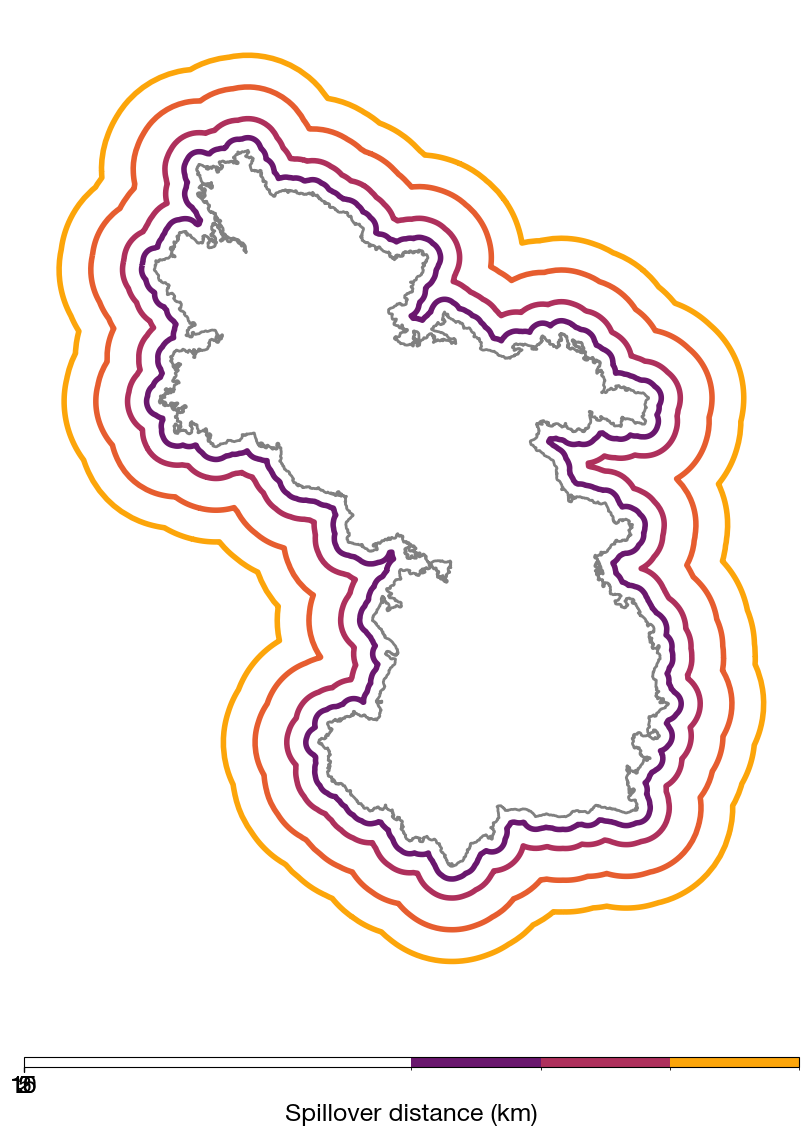

In [31]:
#################### PLOT MAP ####################
event_id = "CA3966012280920200817"

# Assuming final_df is your DataFrame
unique_dist_treats = final_df.dist_treat.unique()
num_colors = len(unique_dist_treats)
green_colors = cm.inferno(np.linspace(0.3, 0.8, num_colors))


# Plot each distance range with a different color
fig, ax = plt.subplots(1, 1, figsize=(10, 20))

mtbs_ca[mtbs_ca.Event_ID == event_id].boundary.plot(
    ax=ax,
    color="gray",
    linewidth=2,
)

for idx, buf in enumerate(unique_dist_treats):
    # Plot the fire perimeter w/ buffer
    geom = mtbs_ca[mtbs_ca.Event_ID == event_id].geometry.buffer(buf)
    geom.boundary.plot(
        ax=ax,
        color=green_colors[idx],
        linewidth=4,
    )

# Create a color axis (cax) below the plot
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="1%", pad=0.5)

# Create a ListedColormap and BoundaryNorm
cmap = ListedColormap(green_colors)
norm = BoundaryNorm(unique_dist_treats + [unique_dist_treats[-1] + 1], cmap.N)

# Add a colorbar
cb = fig.colorbar(
    cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax, orientation="horizontal"
)
cb.set_label("Spillover distance (km)")
cb.set_ticks(unique_dist_treats)
cb.set_ticklabels([f"{int(dist/1000)}" for dist in unique_dist_treats])

# Format the plot
template_plots(ax, no_axis=True, ylab="", xlab="", label_pos=(-0.1, 1.24))


# Save plot as PDF
plt.savefig("../figs/spillover_map.pdf", dpi=300, transparent=True)

## Robustness: spillovers in small fires (< 2000 acres)

In [15]:
dnbr = pd.read_feather(
    "/mnt/sherlock/oak/prescribed_data/processed/dnbr_gee_inmediate/dnbr_long.feather"
)

# Add years using mtbs data
dnbr = dnbr.merge(
    mtbs_ca[["Event_ID", "year"]], left_on="event_id", right_on="Event_ID"
)
dnbr["fire"] = 1

# Load FRP data with nominal confidence and fire with everything where FRP > 0
frp = pd.read_feather(
    "/mnt/sherlock/oak/prescribed_data/processed/frp_nominal_conf/frp_concat.feather"
).drop(columns=["lat", "lon"])

# Load treat defniitions
treats_dist = pd.read_feather(
    "/mnt/sherlock/oak/prescribed_data/processed/distance_treatments_small/wildfire_distances_15000.feather"
).drop(columns=["lat", "lon", "donut", "wildfire"])


raw_dnbr = classify_dnbr(dnbr)
raw_frp = classify_frp(frp)

In [16]:
hc_lists = {
    "All wildfires": [1, 2, 3, 4, 5],
    "High-severity wildfires": [2, 3, 4],
    "Very High-severity wildfires": [3, 4],
}

list_df = []

for key, high_class in hc_lists.items():
    if key == "All wildfires":
        out_df = raw_dnbr[raw_dnbr.class_dnbr.isin(high_class)]
        var = "fire"
    elif key == "High-intensity wildfires":
        out_df = raw_frp[raw_frp.class_frp.isin(high_class)]
        var = "fire"
    elif key == "High-severity wildfires":
        out_df = raw_dnbr[raw_dnbr.class_dnbr.isin(high_class)]
        var = "fire"
    elif key == "Very High-intensity wildfires":
        out_df = raw_frp[raw_frp.class_frp.isin(high_class)]
        var = "fire"
    elif key == "Very High-severity wildfires":
        out_df = raw_dnbr[raw_dnbr.class_dnbr.isin(high_class)]
        var = "fire"

    est_dfs_list = []
    for distance in [2_000, 5_000, 10_000, 15_000]:
        weights = pd.read_csv(
            f"/mnt/sherlock/oak/prescribed_data/results/tyra/treatment_spillovers_{distance}/best_model_asmd_weights.csv"
        )

        past_dist = 0
        df = calculate_spillover_estimator(
            treatments=treats_dist,
            weights=weights,
            fire_data=out_df,
            focal_years=np.arange(2008, 2023),
            max_distance=distance,
            min_distance=past_dist,
            estimator="rr",
            dep_var="fire",
            pooling=True,
            cluster_var="year",
            formula="att ~ lag",
            freq_weights="control_mean",
            max_lags=14,
            rr=True,
        )
        past_dist = distance

        est_dfs_list.append(df)

    df = pd.concat(est_dfs_list)
    df["control_group"] = key
    list_df.append(df)

final_df = pd.concat(list_df)

Calculate estimate for focal year: 100%|██████████| 15/15 [00:00<00:00, 21.39it/s]
/home/topcat/projects/extract/src/prescribed/estimate/calculate_estimator.py:599: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept = coefficients[0]
/home/topcat/projects/extract/src/prescribed/estimate/calculate_estimator.py:600: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  slope = coefficients[1]
/home/topcat/projects/extract/src/prescribed/estimate/calculate_estimator.py:629: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consist

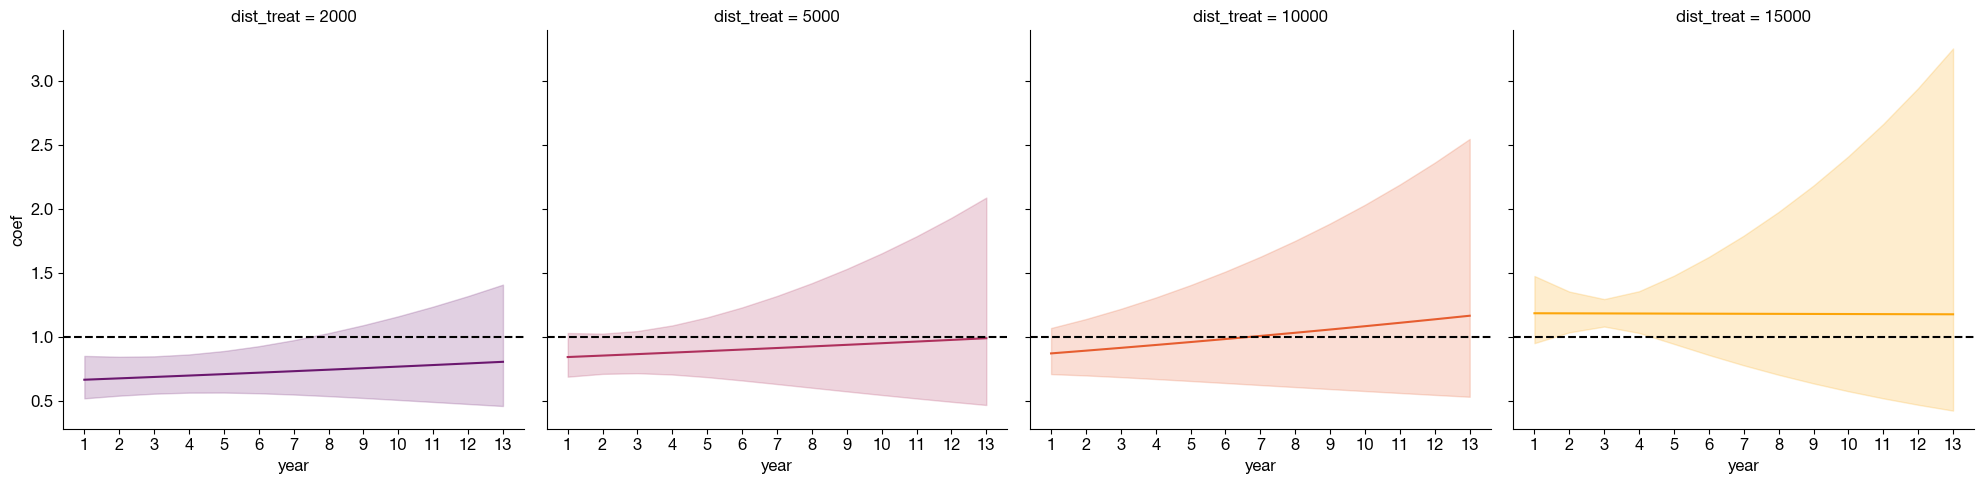

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Assuming final_df is your DataFrame
unique_dist_treats = final_df.dist_treat.unique()
num_colors = len(unique_dist_treats)
green_colors = cm.inferno(np.linspace(0.3, 0.8, num_colors))

# Create a color dictionary
color_dict = {
    dist_treat: color
    for dist_treat, color in zip(unique_dist_treats, green_colors)
}

# Create the relplot
g = sns.relplot(
    data=final_df[final_df.control_group == "All wildfires"],
    x="year",
    y="coef",
    col="dist_treat",
    hue="dist_treat",
    kind="line",
    legend=False,
    palette=color_dict,
    height=5,
    col_wrap=4,
    aspect=1,
    facet_kws={"sharey": True, "sharex": True},
)

# Add fill_between and other elements to each facet
for ax, (dist_treat, data) in zip(g.axes.flat, g.data.groupby(["dist_treat"])):
    data = data.sort_values("year")
    color = color_dict[dist_treat[0]]

    ax.fill_between(
        data["year"], data["low_ci"], data["high_ci"], alpha=0.2, color=color
    )
    ax.axhline(1, color="black", linestyle="--")

    ax.set_xticks(range(1, 14))
    ax.set_xticklabels(range(1, 14))

# Save plot as PDF
# plt.savefig("../figs/spills_robust.pdf", dpi=300, transparent=True)

In [18]:
(
    1
    - final_df[
        (final_df.dist_treat == 2000)
        & (final_df.control_group == "All wildfires")
    ].sort_values("year")[["coef", "low_ci", "high_ci"]]
)

,coef,low_ci,high_ci
9,0.330938,0.476503,0.144897
0,0.320259,0.455511,0.151411
10,0.309411,0.440134,0.148164
11,0.298388,0.432005,0.133340
1,0.287190,0.431302,0.106559
2,0.275814,0.436768,0.068863
3,0.264255,0.446617,0.021798
12,0.252512,0.459286,-0.033332
4,0.240582,0.473647,-0.095682
5,0.228461,0.488953,-0.164809


/tmp/ipykernel_4082136/1564185805.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(
/home/topcat/miniforge3/envs/prescribed/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


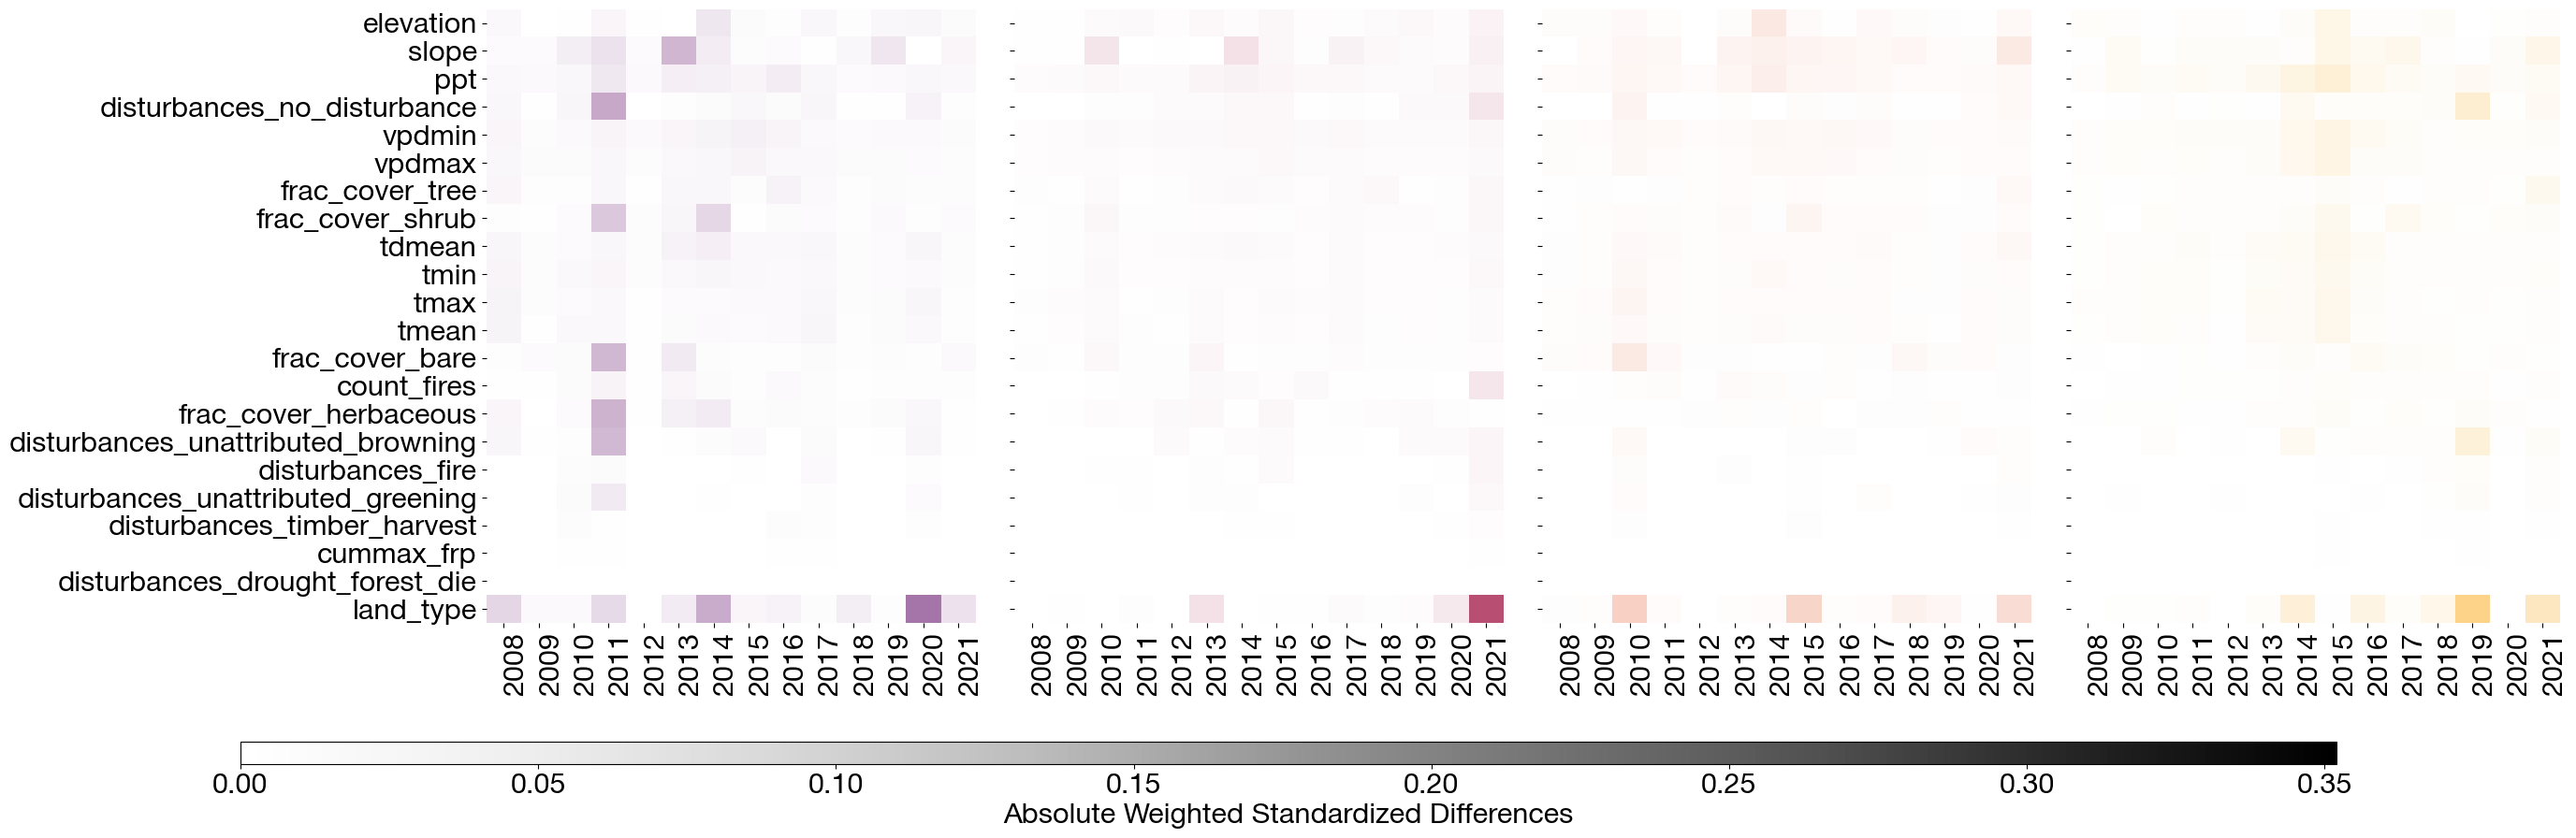

In [13]:
# Set the font size to be 12
plt.rcParams["font.size"] = 22

dists = [2_000, 5_000, 10_000, 15_000]

fig, ax = plt.subplots(
    1, len(dists), figsize=(28, 8), sharey=True, layout="tight"
)
colors = cm.inferno(np.linspace(0.3, 0.8, len(dists)))


min_list = []
max_list = []
for dist, color, ax in zip(dists, colors, ax.flatten()):
    cmap = LinearSegmentedColormap.from_list(
        "", [to_rgba(color, 0), to_rgba(color, 1)]
    )

    _, std_min, std_max = plot_std_diffs(
        std_diffs_df=f"/mnt/sherlock/oak/prescribed_data/results/tyra/treatment_spillovers_{dist}/best_model_asmd_std_diffs.csv",
        palette=cmap,
        ax=ax,
        draw_cbar=False,
        sorted=False,
        labels_y=True,
        rotation_x=90,
        drop_vars=["Intercept", "aspect", "curvature"],
        vmax=0.41154936,
        vmin=8.9584755e-07,
    )
    min_list.append(std_min)
    max_list.append(std_max)

# Add a colorbar at the bottom outside the plot using the max and min of all the data
fig.subplots_adjust(bottom=0.1)
cbar_ax = fig.add_axes([0.1, -0.05, 0.8, 0.03])

# Create the colorbar
sm = plt.cm.ScalarMappable(
    cmap="Grays", norm=plt.Normalize(vmin=min(min_list), vmax=max(max_list))
)
sm._A = []
cbar = fig.colorbar(sm, cax=cbar_ax, orientation="horizontal")
cbar.set_label("Absolute Weighted Standardized Differences", fontsize=22)

# Save as PDF
plt.savefig(
    "../figs/spillover_std_diffs_robust.pdf",
    dpi=400,
    transparent=False,
    bbox_inches="tight",
    pad_inches=0.1,
)

In [24]:
est_dfs_list, est_non_pool_list = [], []
for distance in [2_000, 5_000, 10_000, 15_000]:
    weights = pd.read_csv(
        f"/mnt/sherlock/oak/prescribed_data/results/tyra/treatment_spillovers_{distance}/best_model_loss_weights.csv"
    )

    past_dist = 0
    df = calculate_spillover_estimator(
        treatments=treats_dist,
        weights=weights,
        fire_data=dnbr.dropna(),
        focal_years=np.arange(2008, 2021),
        max_distance=distance,
        min_distance=past_dist,
        estimator="att",
        dep_var="dnbr",
        pooling=True,
        cluster_var="year",
        formula="att ~ lag",
        max_lags=14,
        rr=False,
    )

    est_dfs_list.append(df)

    df_non_pool = calculate_spillover_estimator(
        treatments=treats_dist,
        weights=weights,
        fire_data=dnbr.dropna(),
        focal_years=np.arange(2008, 2021),
        max_distance=distance,
        min_distance=past_dist,
        estimator="att",
        dep_var="dnbr",
        pooling=False,
        cluster_var="year",
        formula="att ~ lag",
        max_lags=14,
        rr=False,
    )
    past_dist = distance

    est_non_pool_list.append(df_non_pool)

df = pd.concat(est_dfs_list)
df_non_pool = pd.concat(est_non_pool_list)


Calculate estimate for focal year:  31%|███       | 4/13 [00:00<00:00, 14.64it/s]

Calculate estimate for focal year: 100%|██████████| 13/13 [00:00<00:00, 16.21it/s]


In [42]:
df_non_pool[df_non_pool.dist_treat == 2000]

,year,treat_mean,treat_var,n_treat,control_mean,control_var,att,focal_year,lag,att_var,att_se,dist_treat
0,2010,93.600182,3633.059814,7,74.844962,124.864490,18.755219,2008,2,76.692333,8.757416,2000
1,2013,530.158508,45670.523438,28,256.431520,81.955280,273.726988,2008,5,58.357753,7.639225,2000
2,2014,123.334465,35560.804688,28,106.756000,84.122246,16.578465,2008,6,45.465468,6.742809,2000
3,2015,55.046104,17680.679688,74,134.843398,64.228620,-79.797294,2008,7,3.240487,1.800135,2000
4,2017,26.931042,4934.381348,25,141.706667,52.414941,-114.775625,2008,9,7.978874,2.824690,2000
5,2018,92.813820,31438.435547,127,187.827850,41.218849,-95.014030,2008,10,1.951742,1.397048,2000
6,2019,339.546631,44267.468750,5,111.908726,660.245226,227.637905,2008,11,1797.108559,42.392317,2000
7,2020,320.726471,107620.757812,301,171.121684,13.945982,149.604787,2008,12,1.188008,1.089958,2000
8,2021,168.780502,57081.410156,86,182.130000,36.151160,-13.349497,2008,13,7.722764,2.778986,2000
0,2010,3.989052,12312.820312,7,-3.572188,1117.283928,7.561240,2009,1,274.083760,16.555475,2000


<Axes: xlabel='Year from treatment', ylabel='ATT'>

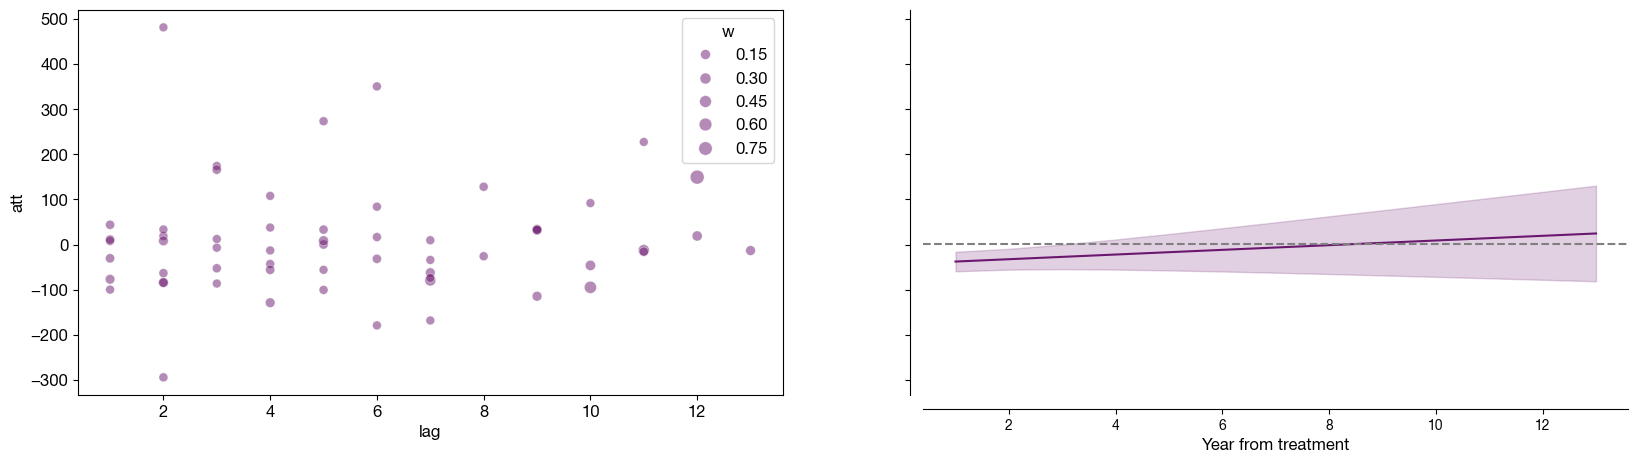

In [ ]:
from prescribed.plot import template_plots

dists = [2_000, 5_000, 10_000, 15_000]
colors = cm.inferno(np.linspace(0.3, 0.8, len(dists)))

cmap = LinearSegmentedColormap.from_list(
    "", [to_rgba(colors[0], 0), to_rgba(colors[0], 1)]
)

fig, ax = plt.subplots(1, 2, figsize=(20, 5), sharey=True)
df.sort_values("year", inplace=True)

df_non_pool["w"] = 1 / df_non_pool["att_var"]

sns.scatterplot(
    data=df_non_pool[df_non_pool.dist_treat == 2000],
    x="lag",
    y="att",
    color=colors[0],
    ax=ax[0],
    alpha=0.5,
    size="w",
    sizes=(40, 100),
)

sns.lineplot(
    data=df[df.dist_treat == 2000],
    x="year",
    y="coef",
    color=colors[0],
    ax=ax[1],
)

ax[1].fill_between(
    df[df.dist_treat == 2000].year,
    df[df.dist_treat == 2000].low_ci,
    df[df.dist_treat == 2000].high_ci,
    alpha=0.2,
    color=colors[0],
)
ax[1].axhline(1, color="gray", linestyle="--")
template_plots(ax[1], ylab="ATT", xlab="Year from treatment")